## 4. Evaluation Metrics for Classification

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## 4.1 Data preparation 

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## 4.2 Categorical and numerical variables

What are the categorical variables? What are the numerical?

In [8]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes == 'int64'].index)

print("categorical: ", categorical_columns)
print("numerical: ", numerical_columns)

categorical:  ['home', 'marital', 'records', 'job']
numerical:  ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price', 'default']


## 4.3 Setting up the validation framework

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
len(df), len(df_train), len(df_val), len(df_test), round(len(df_train)/len(df),2), round(len(df_test)/len(df),2)

(4454, 2672, 891, 891, 0.6, 0.2)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [12]:
from sklearn.metrics import roc_auc_score

In [13]:
numerical_columns_ = numerical_columns.copy()
numerical_columns_.remove('default')

scores = {}

for col in numerical_columns_:
    auc_val = roc_auc_score(df_train['default'], df_train[col])
    if auc_val < 0.5:
        auc_val = roc_auc_score(df_train['default'], -df_train[col])
    
    scores[col]=round(auc_val, 5)
    
    print(col, "\t", round(auc_val, 5))

seniority 	 0.70938
time 	 0.56087
age 	 0.57329
expenses 	 0.50092
income 	 0.68201
assets 	 0.6486
debt 	 0.50478
amount 	 0.59108
price 	 0.50433


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

In [14]:
print("\nmax score: ", max(scores.values()))

print("variable: ", list(scores.keys())[list(scores.values()).index(max(scores.values()))])


max score:  0.70938
variable:  seniority


## 4.4 Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

feature_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [16]:
def vectorized_features(df_train, df_val, cols):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train[cols].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = df_val[cols].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    
    return X_train, X_val

X_train, X_val = vectorized_features(df_train, df_val, feature_cols)

In [17]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [18]:
y_pred = model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [19]:
round(roc_auc_score(y_val, y_pred), 3)

0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []

thresholds = np.linspace(0.0, 1.0, 101)

for t in thresholds:
    precision = pd.NA
    recall = pd.NA
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    all_positives_predicted = tp + fp
    all_positives_actual = tp + fn
    
    if all_positives_predicted > 0:
        precision = tp / all_positives_predicted
    
    if all_positives_actual > 0:
        recall = tp / all_positives_actual
    
    scores.append((t, precision, recall))

In [21]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores = df_scores.dropna()

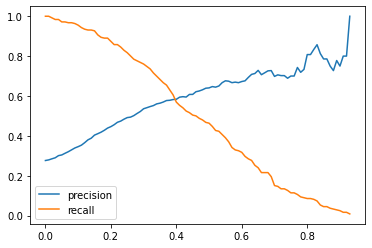

In [22]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

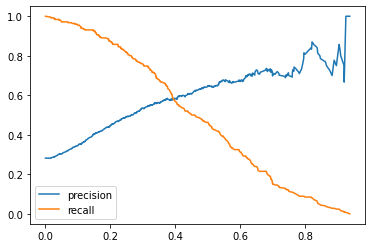

In [23]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

thresholds = np.concatenate([[0.0],thresholds])

plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, recall, label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [24]:
df_scores['F1'] = 2 * (df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall))

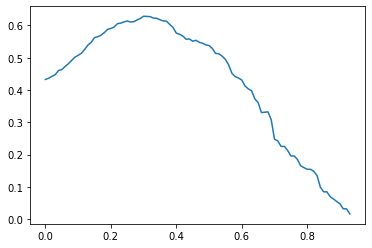

In [25]:
plt.plot(df_scores.threshold, df_scores.F1)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [26]:
print(round(df_scores['F1'].max(),2))
print(df_scores[df_scores['F1'] == df_scores['F1'].max()]['threshold'])

0.63
30    0.3
Name: threshold, dtype: float64


In [27]:
from sklearn.metrics import f1_score

best_threshold = 0.3

val_pred = (model.predict_proba(X_val)[:,1]>=best_threshold).astype(int)
lr_f1 = f1_score(y_val, val_pred)

print(round(lr_f1,2))

0.63


## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [28]:
# !pip install tqdm
from tqdm.auto import tqdm

In [29]:
from sklearn.model_selection import KFold

In [30]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [31]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train[['default'] + feature_cols]):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values
    
    del df_train['default']
    del df_val['default']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc_score = roc_auc_score(y_val, y_pred)
    scores.append(auc_score)

print(scores)
print("standard devidation of the scores across different folds: ", round(np.std(scores), 3))

[0.8555786555786556, 0.8654827880738136, 0.8300219210840972, 0.8537220453562866, 0.8194889841170738]
standard devidation of the scores across different folds:  0.017


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [33]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train[['default'] + feature_cols]):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values
    
        del df_train['default']
        del df_val['default']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s\t %.3f\t +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01	 0.836	 +- 0.019
C=0.1	 0.843	 +- 0.017
C=1	 0.845	 +- 0.017
C=10	 0.845	 +- 0.018


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.